In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

DOMAIN = 'bike'
DB = 'postgres'

if DB == 'postgres':
    db_dict = {
        'test':   'postgres://localhost:5432/babble_model_unittest',
        'spouse': 'postgres://localhost:5432/babble_model_spouse',
        'bike':   'postgres://localhost:5432/babble_model_bike',
        'cdr':    'postgres://localhost:5432/babble_model_cdr',
    }
    os.environ['SNORKELDB'] = db_dict[DOMAIN]
elif DB == 'sqlite':
    os.remove('snorkel.db')
    import shutil
    shutil.copy2('bike/snorkel.db', './')

In [3]:
from snorkel import SnorkelSession
session = SnorkelSession()

In [4]:
from snorkel.contrib.babble.models import configuration

config = configuration
config['domain'] = DOMAIN
config['splits'] = [0,1]
config['babbler_split'] = 0
config['max_docs'] = None
config['parallelism'] = 1
config['traditional'] = False
config['majority_vote'] = True
config['verbose'] = True
config['display_marginals'] = True
config['display_accuracies'] = True
config['display_learned_accuracies'] = True

In [5]:
from snorkel.models import candidate_subclass
from tutorials.babble import MTurkHelper
from snorkel.contrib.babble import ExplanationIO

if DOMAIN == 'spouse':
    from tutorials.babble.spouse import SpouseModel
    Spouse = candidate_subclass('Spouse', ['person1', 'person2'])
    candidate_class = Spouse
    
    expio = ExplanationIO()
    fpath = (os.environ['SNORKELHOME'] + 
        '/tutorials/babble/spouse/data/mturk_explanations_all.tsv')
    explanations = expio.read(fpath)
    
    sm = SpouseModel(session, Spouse, config)
elif DOMAIN == 'bike':
    from tutorials.babble.bike import BikeModel
    Biker = candidate_subclass('Biker', ['person', 'bike'])
    candidate_class = Biker
    
    helper = MTurkHelper()
    output_csv_path = (os.environ['SNORKELHOME'] + 
                       '/tutorials/babble/bike/data/VisualGenome_all_out.csv')
    explanations = helper.postprocess_visual(output_csv_path, set_name='train', verbose=False)
    
    sm = BikeModel(session, Biker, config)    
else:
    raise Exception('Invalid domain: {}'.format(DOMAIN))
user_lists = {}
print("Total explanations: {}".format(len(explanations)))

Num HITs unique: 40
Num HITs total: 120
Unanimous: 99
Majority: 33
Bad: 27
Total explanations: 367


In [ ]:
# anns_folder = '/dfs/scratch0/paroma/coco/annotations/'
# anns_folder = os.environ['SNORKELHOME'] + '/tutorials/babble/bike/data/'
# %time sm.parse(anns_folder)

In [ ]:
%time sm.parse(config=config)

In [ ]:
%time sm.extract(config=config)

In [ ]:
%time sm.load_gold(config=config)

In [6]:
from snorkel.annotations import load_gold_labels
L_gold_train = load_gold_labels(session, annotator_name='gold', split=0)
L_gold_train

<2406x1 sparse matrix of type '<type 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [7]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<1037x1 sparse matrix of type '<type 'numpy.int64'>'
	with 906 stored elements in Compressed Sparse Row format>

In [8]:
candidates = session.query(candidate_class).filter(
    candidate_class.split == config['babbler_split']).all()
# candidates = session.query(candidate_class).filter(candidate_class.split == 0).all()
print(len(candidates))

2406


In [9]:
from snorkel.contrib.babble import link_explanation_candidates

explanations = link_explanation_candidates(explanations, candidates)

Building list of target candidate ids...
Collected 131 unique target candidate ids from 367 explanations.
Gathering desired candidates...
Found 131/131 desired candidates
Linking explanations to candidates...
Linked 367/367 explanations


In [10]:
%time sm.babble(explanations, user_lists=user_lists, config=config)

Calling babbler...
Created grammar with 422 rules
340 parses created from 247 out of 367 explanation(s)
Filtered to 101 LFs with duplicate semantics filter (239 filtered).
Filtered to 59 LFs with consistency filter (42 filtered).
Clearing existing...
Running UDF...
[========================================] 100%

Filtered to 51 LFs with uniform signatures filter (8 filtered).
Filtered to 34 LFs with duplicate signatures filter (17 filtered).
CPU times: user 37.9 s, sys: 2.77 s, total: 40.7 s
Wall time: 1min 2s


In [12]:
sm.babbler.get_explanations()[:5]

[Explanation("Explanation11: False, Box X is a lot smaller than Box Y."),
 Explanation("Explanation12: False, Box X is to the left of Box Y."),
 Explanation("Explanation151: False, Box Y is high and to the left of Box X, and is also a lot smaller"),
 Explanation("Explanation16: False, The bottom edge of Box X is below the bottom edge of Box Y."),
 Explanation("Explanation177: True, The bottom edge of box X is at the center of box Y.")]

In [13]:
sm.babbler.get_parses()[:5]

['return -1 if call(smaller(Box X), Box Y) else 0',
 'return -1 if call(left(Box X), Box Y) else 0',
 'return -1 if call(left(Box Y), Box X) else 0',
 "return -1 if call(below(edge(Box X, 'bottom')), edge(Box Y, 'bottom')) else 0",
 "return 1 if call(near(center(Box X)), edge(Box Y, 'bottom')) else 0"]

In [14]:
%time sm.label(config=config)

Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 0: (2406,34) sparse (nnz = 43999)
Clearing existing...
Running UDF...
[========================================] 100%


Labeled split 1: (1037,34) sparse (nnz = 18682)
CPU times: user 35.4 s, sys: 2.09 s, total: 37.5 s
Wall time: 55.3 s


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
Explanation5_0,0,0.274831,0.274831,0.274831,154,87,0,0,0.639004
Explanation6_0,1,0.400193,0.400193,0.400193,0,0,84,235,0.736677
Explanation11_0,2,0.369335,0.369335,0.369335,0,0,68,268,0.797619
Explanation12_0,3,0.493732,0.493732,0.493732,0,0,98,341,0.776765
Explanation16_0,4,0.377049,0.377049,0.377049,0,0,15,339,0.957627
Explanation18_0,5,0.814851,0.814851,0.814851,202,541,0,0,0.271871
Explanation19_0,6,0.505304,0.505304,0.505304,109,354,0,0,0.235421
Explanation25_0,7,0.620058,0.620058,0.620058,184,351,0,0,0.343925
Explanation29_1,8,0.994214,0.994214,0.994214,0,0,210,690,0.766667
Explanation31_0,9,0.494696,0.494696,0.494696,0,0,103,350,0.772627


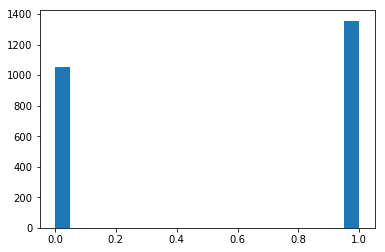

CPU times: user 1.11 s, sys: 119 ms, total: 1.23 s
Wall time: 1.29 s


In [16]:
%time sm.supervise(config=config)

In [21]:
L_dev = sm.labeler.load_matrix(session, split=1)
L_dev

<1037x34 sparse matrix of type '<type 'numpy.int64'>'
	with 18682 stored elements in Compressed Sparse Row format>

In [23]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<1037x1 sparse matrix of type '<type 'numpy.int64'>'
	with 906 stored elements in Compressed Sparse Row format>

In [24]:
L_dev.lf_stats(session, L_gold_dev)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
Explanation5_0,0,0.274831,0.274831,0.274831,154,87,0,0,0.639004
Explanation6_0,1,0.400193,0.400193,0.400193,0,0,84,235,0.736677
Explanation11_0,2,0.369335,0.369335,0.369335,0,0,68,268,0.797619
Explanation12_0,3,0.493732,0.493732,0.493732,0,0,98,341,0.776765
Explanation16_0,4,0.377049,0.377049,0.377049,0,0,15,339,0.957627
Explanation18_0,5,0.814851,0.814851,0.814851,202,541,0,0,0.271871
Explanation19_0,6,0.505304,0.505304,0.505304,109,354,0,0,0.235421
Explanation25_0,7,0.620058,0.620058,0.620058,184,351,0,0,0.343925
Explanation29_1,8,0.994214,0.994214,0.994214,0,0,210,690,0.766667
Explanation31_0,9,0.494696,0.494696,0.494696,0,0,103,350,0.772627


In [25]:
tp, fp, tn, fn = sm.gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.905
Neg. class accuracy: 0.579
Precision            0.353
Recall               0.905
F1                   0.508
----------------------------------------
TP: 190 | FP: 348 | TN: 479 | FN: 20



In [ ]:
# %time sm.classify()

In [ ]:
L_train = sm.labeler.load_matrix(session, split=0)
L_train

In [ ]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch, ListParameter, RangeParameter

epochs_param    = ListParameter('epochs', [5, 10, 20])
decay_param     = ListParameter('decay', [0.9, 0.95])
step_size_param = RangeParameter('step_size', 1e-6, 1e-5, step=1, log_base=10)
reg_param       = ListParameter('reg_param', [1e-6])

searcher = RandomSearch(GenerativeModel, 
                        [step_size_param, decay_param, epochs_param, reg_param],
                        L_train, n=5)

In [ ]:
%%time
gen_model_best, run_stats = searcher.fit(L_dev, L_gold_dev)
run_stats

In [ ]:
gen_model_best = GenerativeModel(class_prior=False, lf_prior=False, 
                                 lf_propensity=False, lf_class_propensity=False)

In [ ]:
gen_model_best.train(L_train, epochs=10, decay=0.95, step_size=1e-6, reg_param=1e-6)

In [ ]:
tp, fp, tn, fn = gen_model_best.error_analysis(session, L_dev, L_gold_dev, b=0.8)

In [ ]:
import matplotlib.pyplot as plt

train_marginals = gen_model_best.marginals(L_train)
plt.hist(train_marginals, bins=30)
plt.show()